# FloPy

## MODPATH 7 create simulation example

This notebook demonstrates how to create a simple forward and backward MODPATH 7 simulation using the `.create_mp7()` method. The notebooks also shows how to create subsets of endpoint output and plot MODPATH results on ModelMap objects.

In [1]:
%matplotlib inline
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

    print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

if not os.path.exists("data"):
    os.mkdir("data")

numpy version: 1.14.3
matplotlib version: 2.2.0
flopy version: 3.2.9


### Flow model data

In [2]:
nper, nstp, perlen, tsmult = 1, 1, 1., 1.
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.
top = 400.
botm = [220., 200., 0.]
laytyp = [1, 0, 0]
kh = [50., 0.01, 200.]
kv = [10., 0.01, 20.]
wel_loc = (2, 10, 9)
wel_q = -150000.
rch = 0.005
riv_h = 320.
riv_z = 317.
riv_c = 1.e5

### MODPATH 7 using MODFLOW-2005

#### Create and run MODFLOW-2005

In [3]:
ws = os.path.join('data', 'mp7_ex1_cs')
nm = 'ex01_mf2005'
exe_name = 'mf2005'
iu_cbc = 130
m = flopy.modflow.Modflow(nm, model_ws=ws,
                          exe_name=exe_name)
flopy.modflow.ModflowDis(m, nlay=nlay, nrow=nrow, ncol=ncol,
                         nper=nper, itmuni=4 , lenuni=1,
                         perlen=perlen, nstp=nstp,
                         tsmult=tsmult, steady=True,
                         delr=delr, delc=delc,
                         top=top, botm=botm)
flopy.modflow.ModflowLpf(m, ipakcb=iu_cbc, laytyp=laytyp, hk=kh, vka=kv)
flopy.modflow.ModflowBas(m, ibound=1, strt=top)
# recharge
flopy.modflow.ModflowRch(m, ipakcb=iu_cbc, rech=rch)
# wel
wd = [i for i in wel_loc] + [wel_q]
flopy.modflow.ModflowWel(m, ipakcb=iu_cbc, stress_period_data={0: wd})
# river
rd = []
for i in range(nrow):
    rd.append([0, i, ncol-1, riv_h, riv_c, riv_z])
flopy.modflow.ModflowRiv(m, ipakcb=iu_cbc, stress_period_data={0: rd})
# output control
flopy.modflow.ModflowOc(m, stress_period_data={(0, 0): ['save head',
                                                        'save budget',
                                                        'print head']})
flopy.modflow.ModflowPcg(m, hclose=1e-6, rclose=1e-6)

m.write_input()
success, buff = m.run_model()
assert success, 'mf2005 model did not run'

FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ex01_mf2005.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/10/09 18:51:32

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/10/09 18:51:32
 Elapsed run time:  0.016 Seconds

  Normal termination of simulation


In [4]:
# this is a fix until the grid object is available
m.sr = flopy.utils.SpatialReference(xll=0, yll=0, delr=m.dis.delr.array, delc=m.dis.delc.array, 
                                    units='meters', lenuni=1, length_multiplier=1)

#### Create and run MODPATH 7

Forward tracking

In [5]:
# create modpath files
mpnamf = nm + '_mp_forward'

# create basic forward tracking modpath simulation
mp = flopy.modpath.Modpath7.create_mp7(modelname=mpnamf, trackdir='forward', flowmodel=m, model_ws=ws, 
                                       rowcelldivisions=1, columncelldivisions=1, layercelldivisions=1)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mp7

MODPATH Version 7.2.001   
Program compiled Oct  6 2018 20:35:47 with GFORTRAN compiler (ver. 8.2.0)       


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
      1260 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

Backward tracking

In [6]:
# create modpath files
mpnamb = nm + '_mp_backward'

# create basic forward tracking modpath simulation
mp = flopy.modpath.Modpath7.create_mp7(modelname=mpnamb, trackdir='backward', flowmodel=m, model_ws=ws, 
                                       rowcelldivisions=1, columncelldivisions=1, layercelldivisions=1)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mp7

MODPATH Version 7.2.001   
Program compiled Oct  6 2018 20:35:47 with GFORTRAN compiler (ver. 8.2.0)       


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
      1260 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

#### Load MODPATH 7 output

Get locations to extract data

In [7]:
nodew = m.dis.get_node([wel_loc])
riv_locs = flopy.utils.ra_slice(m.riv.stress_period_data[0], ['k', 'i', 'j'])
nodesr = m.dis.get_node(riv_locs.tolist())

Forward tracking pathline data

In [8]:
fpth = os.path.join(ws, mpnamf + '.mppth')
p = flopy.utils.PathlineFile(fpth)
pw = p.get_destination_pathline_data(dest_cells=nodew)
pr = p.get_destination_pathline_data(dest_cells=nodesr)

Forward tracking endpoint data

In [9]:
fpth = os.path.join(ws, mpnamf + '.mpend')
e = flopy.utils.EndpointFile(fpth)

Get forward particles that terminate in the well

In [10]:
well_epd = e.get_destination_endpoint_data(dest_cells=nodew) 

Get particles that terminate in the river boundaries

In [11]:
riv_epd = e.get_destination_endpoint_data(dest_cells=nodesr)

Merge the particles that end in the well and the river boundaries.

In [12]:
epd0 = np.concatenate((well_epd, riv_epd))

#### Plot MODPATH 7 output

Well and river forward tracking pathlines

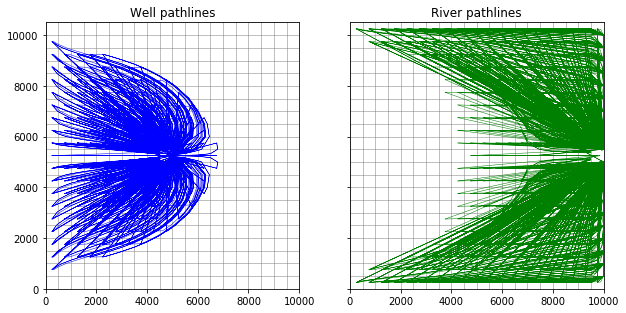

In [13]:
f, axes = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(10, 5))
axes = axes.flatten()

ax = axes[0]
ax.set_aspect('equal')
ax.set_title('Well pathlines')
mm = flopy.plot.ModelMap(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pw, layer='all', color='blue', lw=0.5)

ax = axes[1]
ax.set_aspect('equal')
ax.set_title('River pathlines')
mm = flopy.plot.ModelMap(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pr, layer='all', color='green', lw=0.5);


#### Plot MODPATH 7 output

Forward tracking endpoints captured by the well and river

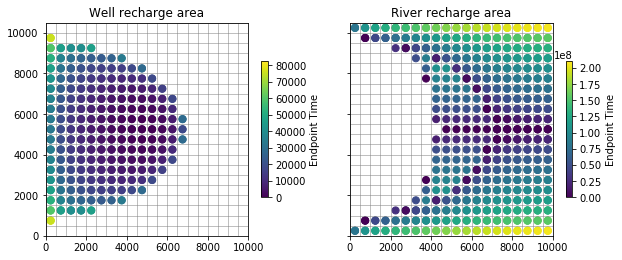

In [14]:
f, axes = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(10, 5))
axes = axes.flatten()

ax = axes[0]
ax.set_aspect('equal')
ax.set_title('Well recharge area')
mm = flopy.plot.ModelMap(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_endpoint(well_epd, direction='starting', colorbar=True, shrink=0.5);

ax = axes[1]
ax.set_aspect('equal')
ax.set_title('River recharge area')
mm = flopy.plot.ModelMap(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_endpoint(riv_epd, direction='starting', colorbar=True, shrink=0.5);

Backward tracking pathlines

In [15]:
fpth = os.path.join(ws, mpnamb + '.mppth')
p = flopy.utils.PathlineFile(fpth)
pwb = p.get_destination_pathline_data(dest_cells=nodew)

Backward tracking endpoints

In [16]:
fpth = os.path.join(ws, mpnamb + '.mpend')
e = flopy.utils.EndpointFile(fpth)
well_epdb = e.get_destination_endpoint_data(dest_cells=nodew) 

#### Plot MODPATH 7 output

Well backward tracking pathlines